<a href="https://colab.research.google.com/github/Yakuy/Gemastik13/blob/Pujo/Experimental.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initilization & Lib

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15835491845176698493, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16087797175892402665
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 3084602422380275120
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11146783616
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6334209431138038619
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [ ]:
#!pip3 install torch==0.3.1 torchvision==0.2.0

In [3]:
#capsnet
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
#chexnet
import sys
import argparse
import torch
import torch.nn as nn
import torchvision
from collections import OrderedDict
#train network
import os
import datetime
import json
import glob
import torch.backends.cudnn as cudnn
from torch import optim
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc, f1_score
import seaborn as sn
import pandas as pd
from scipy import interp
from itertools import cycle
from tqdm import tqdm
#load data
from torch.utils.data import Dataset
import random
from PIL import Image

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
#buat load data
class ChestXrayDataSetTest(Dataset):
    def __init__(self, image_list_file, transform=None, combine_pneumonia=False):
        """
        Create the Data Loader.
        Since class 3 (Covid) has limited data, dataset size will be accordingly at train time.
        Code is written in generic form to assume last class as the rare class

        Args:
            image_list_file: path to the file containing images
                with corresponding labels.
            transform: optional transform to be applied on a sample.
            combine_pneumonia: True for combining Baterial and Viral Pneumonias into one class
        """
        self.NUM_CLASSES = 3 if combine_pneumonia else 4
        # Set of images for each class
        image_names = []

        with open(image_list_file, "r") as f:
            for line in f:
                items = line.split()
                image_name = items[0]+' '+items[1]
                label = int(items[2])
                image_names.append((image_name, label))

        self.image_names = image_names
        self.transform = transform

    def __getitem__(self, index):
        """
        Args:
            index: the index of item

        Returns:
            image and its labels
        """
        def __one_hot_encode(l):
            v = [0] * self.NUM_CLASSES
            v[l] = 1
            return v

        image_name, label = self.image_names[index]
        #label = __one_hot_encode(label)
        #print(label)
        image = Image.open(image_name).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.image_names)


class ChestXrayDataSet(Dataset):
    def __init__(self, image_list_file, transform=None, combine_pneumonia=False):
        """
        Create the Data Loader.
        Since class 3 (Covid) has limited data, dataset size will be accordingly at train time.
        Code is written in generic form to assume last class as the rare class

        Args:
            image_list_file: path to the file containing images
                with corresponding labels.
            transform: optional transform to be applied on a sample.
            combine_pneumonia: True for combining Baterial and Viral Pneumonias into one class
        """
        self.NUM_CLASSES = 3 if combine_pneumonia else 4
        
        # Set of images for each class
        image_names = [[] for _ in range(self.NUM_CLASSES)]

        with open(image_list_file, "r") as f:
            for line in f:
                items = line.split()
                image_name = items[0]+ ' ' + items[1]
                label = int(items[2])
                image_names[label].append(image_name)
        #print(image_list_file)
        #print(image_names)

        self.image_names = image_names
        self.transform = transform
        label_dist = [len(cnames) for cnames in image_names]

        # Number of images of each class desired
        self.num_covid = int(label_dist[-1])
        if combine_pneumonia:
            covid_factor = 7.0
            self.num_normal = int(self.num_covid * covid_factor)
            self.num_pneumonia = int(self.num_covid * covid_factor)
            self.total = self.num_covid + self.num_pneumonia + self.num_normal
            self.loss_weight_minus = torch.FloatTensor([self.num_normal, self.num_pneumonia, self.num_covid]).unsqueeze(0).cuda() / self.total
            self.loss_weight_plus = 1.0 - self.loss_weight_minus
        else:
            covid_factor = 5.0
            self.num_normal = int(self.num_covid * covid_factor)
            self.num_viral = int(self.num_covid * covid_factor)
            self.num_bact = int(self.num_covid * covid_factor)
            self.total = self.num_covid + self.num_viral + self.num_bact + self.num_normal
            self.loss_weight_minus = torch.FloatTensor([self.num_normal, self.num_bact, self.num_viral, self.num_covid]).unsqueeze(0).cuda() / self.total
            self.loss_weight_plus = 1.0 - self.loss_weight_minus

        # print (self.loss_weight_plus, self.loss_weight_minus)

        if combine_pneumonia:
            self.partitions = [self.num_covid,
                                self.num_covid + self.num_normal,
                                self.num_covid + self.num_normal + self.num_pneumonia]
        else:
            self.partitions = [self.num_covid,
                                self.num_covid + self.num_normal,
                                self.num_covid + self.num_normal + self.num_bact,
                                self.num_covid + self.num_normal + self.num_bact + self.num_viral]

        assert len(self.partitions) == self.NUM_CLASSES

    def __getitem__(self, index):
        """
        Args:
            index: the index of item

        Returns:
            image and its labels
        """

        def __one_hot_encode(l):
            v = [0] * self.NUM_CLASSES
            v[l] = 1
            return v

        image_name = None
        # print (index, self.partitions, len(self), sum([len(cnames) for cnames in self.image_names]))
        if index < self.partitions[0]:
            # Return a covid image
            data_idx = index
            image_name = self.image_names[self.NUM_CLASSES - 1][data_idx]
            #print(self.NUM_CLASSES - 1)
            label = self.NUM_CLASSES - 1
        else:
            # Return non-covid image
            for l in range(1, self.NUM_CLASSES):
                if index < self.partitions[l]:
                    class_idx = l - 1
                    #print(class_idx)
                    label = class_idx
                    # Return a random image
                    image_name = random.choice(self.image_names[class_idx])
                    break
        assert image_name is not None
        image = Image.open(image_name).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return self.partitions[-1]

    def loss(self, output, target):
        """
        Binary weighted cross-entropy loss for each class
        """
        weight_plus = torch.autograd.Variable(self.loss_weight_plus.repeat(1, target.size(0)).view(-1, self.loss_weight_plus.size(1)).cuda())
        weight_neg = torch.autograd.Variable(self.loss_weight_minus.repeat(1, target.size(0)).view(-1, self.loss_weight_minus.size(1)).cuda())

        loss = output
        pmask = (target >= 0.5).data
        nmask = (target < 0.5).data
        
        epsilon = 1e-15
        loss[pmask] = (loss[pmask] + epsilon).log() * weight_plus[pmask]
        loss[nmask] = (1-loss[nmask] + epsilon).log() * weight_plus[nmask]
        loss = -loss.sum()
        return loss

In [5]:
TRAIN_IMAGE_LIST = '/content/drive/My Drive/CovidAID/data/new_train.txt'
VAL_IMAGE_LIST = '/content/drive/My Drive/CovidAID/data/new_val.txt'
TEST_IMAGE_LIST = '/content/drive/My Drive/CovidAID/data/new_test.txt'
TEST_DIR = '/content/drive/My Drive/CovidAID/data/samples'


## CapsNet PyTorch Implementation
Author: Xifeng Guo, E-mail: `guoxifeng1990@163.com`, Github: `https://github.com/XifengGuo/CapsNet-Pytorch`

#### Capsnet Class

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from torch.optim import Adam, lr_scheduler
from torchvision import transforms, datasets

def squash(inputs, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param inputs: vectors to be squashed
    :param axis: the axis to squash
    :return: a Tensor with same size as inputs
    """
    norm = torch.norm(inputs, p=2, dim=axis, keepdim=True)
    scale = norm**2 / (1 + norm**2) / (norm + 1e-8)
    return scale * inputs


class DenseCapsule(nn.Module):
    """
    The dense capsule layer. It is similar to Dense (FC) layer. Dense layer has `in_num` inputs, each is a scalar, the
    output of the neuron from the former layer, and it has `out_num` output neurons. DenseCapsule just expands the
    output of the neuron from scalar to vector. So its input size = [None, in_num_caps, in_dim_caps] and output size = \
    [None, out_num_caps, out_dim_caps]. For Dense Layer, in_dim_caps = out_dim_caps = 1.
    :param in_num_caps: number of cpasules inputted to this layer
    :param in_dim_caps: dimension of input capsules
    :param out_num_caps: number of capsules outputted from this layer
    :param out_dim_caps: dimension of output capsules
    :param routings: number of iterations for the routing algorithm
    """
    def __init__(self, in_num_caps, in_dim_caps, out_num_caps, out_dim_caps, routings=3):
        super(DenseCapsule, self).__init__()
        self.in_num_caps = in_num_caps
        self.in_dim_caps = in_dim_caps
        self.out_num_caps = out_num_caps
        self.out_dim_caps = out_dim_caps
        self.routings = routings
        self.weight = nn.Parameter(0.01 * torch.randn(out_num_caps, in_num_caps, out_dim_caps, in_dim_caps))

    def forward(self, x):
        # x.size=[batch, in_num_caps, in_dim_caps]
        # expanded to    [batch, 1,            in_num_caps, in_dim_caps,  1]
        # weight.size   =[       out_num_caps, in_num_caps, out_dim_caps, in_dim_caps]
        # torch.matmul: [out_dim_caps, in_dim_caps] x [in_dim_caps, 1] -> [out_dim_caps, 1]
        # => x_hat.size =[batch, out_num_caps, in_num_caps, out_dim_caps]
        x_hat = torch.squeeze(torch.matmul(self.weight, x[:, None, :, :, None]), dim=-1)

        # In forward pass, `x_hat_detached` = `x_hat`;
        # In backward, no gradient can flow from `x_hat_detached` back to `x_hat`.
        x_hat_detached = x_hat.detach()

        # The prior for coupling coefficient, initialized as zeros.
        # b.size = [batch, out_num_caps, in_num_caps]
        b = Variable(torch.zeros(x.size(0), self.out_num_caps, self.in_num_caps)).cuda()

        assert self.routings > 0, 'The \'routings\' should be > 0.'
        for i in range(self.routings):
            # c.size = [batch, out_num_caps, in_num_caps]
            c = F.softmax(b, dim=1)

            # At last iteration, use `x_hat` to compute `outputs` in order to backpropagate gradient
            if i == self.routings - 1:
                # c.size expanded to [batch, out_num_caps, in_num_caps, 1           ]
                # x_hat.size     =   [batch, out_num_caps, in_num_caps, out_dim_caps]
                # => outputs.size=   [batch, out_num_caps, 1,           out_dim_caps]
                outputs = squash(torch.sum(c[:, :, :, None] * x_hat, dim=-2, keepdim=True))
                # outputs = squash(torch.matmul(c[:, :, None, :], x_hat))  # alternative way
            else:  # Otherwise, use `x_hat_detached` to update `b`. No gradients flow on this path.
                outputs = squash(torch.sum(c[:, :, :, None] * x_hat_detached, dim=-2, keepdim=True))
                # outputs = squash(torch.matmul(c[:, :, None, :], x_hat_detached))  # alternative way

                # outputs.size       =[batch, out_num_caps, 1,           out_dim_caps]
                # x_hat_detached.size=[batch, out_num_caps, in_num_caps, out_dim_caps]
                # => b.size          =[batch, out_num_caps, in_num_caps]
                b = b + torch.sum(outputs * x_hat_detached, dim=-1)

        return torch.squeeze(outputs, dim=-2)


class PrimaryCapsule(nn.Module):
    """
    Apply Conv2D with `out_channels` and then reshape to get capsules
    :param in_channels: input channels
    :param out_channels: output channels
    :param dim_caps: dimension of capsule
    :param kernel_size: kernel size
    :return: output tensor, size=[batch, num_caps, dim_caps]
    """
    def __init__(self, in_channels, out_channels, dim_caps, kernel_size, stride=1, padding=0):
        super(PrimaryCapsule, self).__init__()
        self.dim_caps = dim_caps
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)

    def forward(self, x):
        outputs = self.conv2d(x)
        outputs = outputs.view(x.size(0), -1, self.dim_caps)
        return squash(outputs)

class CapsuleNet(nn.Module):
    """
    A Capsule Network on MNIST.
    :param input_size: data size = [channels, width, height]
    :param classes: number of classes
    :param routings: number of routing iterations
    Shape:
        - Input: (batch, channels, width, height), optional (batch, classes) .
        - Output:((batch, classes), (batch, channels, width, height))
    """
    def __init__(self, input_size, classes, routings):
        super(CapsuleNet, self).__init__()
        self.input_size = input_size
        self.classes = classes
        self.routings = routings

        # Layer 1: Just a conventional Conv2D layer
        self.conv1 = nn.Conv2d(input_size[0], 256, kernel_size=25, stride=2, padding=0)
        # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_caps, dim_caps]
        self.primarycaps = PrimaryCapsule(256, 256, 8, kernel_size=25, stride=16, padding=0)
        # Layer 3: Capsule layer. Routing algorithm works here.
        self.capsulelayer = DenseCapsule(in_num_caps=32*5*5, in_dim_caps=8,
                                         out_num_caps=32*5*5, out_dim_caps=8,routings=routings)
        # Layer 4: Capsule layer. Routing algorithm works here.
        self.digitcaps = DenseCapsule(in_num_caps=32*5*5, in_dim_caps=8,
                                      out_num_caps=classes, out_dim_caps=16, routings=routings)

        # Decoder network.
        self.decoder = nn.Sequential(
            nn.Linear(16*classes, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, input_size[0] * input_size[1] * input_size[2]),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU()

    def forward(self, x, y=None):
        x = self.relu(self.conv1(x))
        x = self.primarycaps(x)
        x = self.digitcaps(x)
        length = x.norm(dim=-1)
        if y is None:  # during testing, no label given. create one-hot coding using `length`
            index = length.max(dim=1)[1]
            y = Variable(torch.zeros(length.size()).scatter_(1, index.view(-1, 1).cpu().data, 1.).cuda())
        reconstruction = self.decoder((x * y[:, :, None]).view(x.size(0), -1))
        return length, reconstruction.view(-1, *self.input_size)


def caps_loss(y_true, y_pred, x, x_recon, lam_recon):
    """
    Capsule loss = Margin loss + lam_recon * reconstruction loss.
    :param y_true: true labels, one-hot coding, size=[batch, classes]
    :param y_pred: predicted labels by CapsNet, size=[batch, classes]
    :param x: input data, size=[batch, channels, width, height]
    :param x_recon: reconstructed data, size is same as `x`
    :param lam_recon: coefficient for reconstruction loss
    :return: Variable contains a scalar loss value.
    """
    L = y_true * torch.clamp(0.9 - y_pred, min=0.) ** 2 + \
        0.5 * (1 - y_true) * torch.clamp(y_pred - 0.1, min=0.) ** 2
    L_margin = L.sum(dim=1).mean()

    L_recon = nn.MSELoss()(x_recon, x)

    return L_margin + lam_recon * L_recon


def show_reconstruction(model, test_loader, n_images, args):
    import matplotlib.pyplot as plt
    from PIL import Image
    import numpy as np
    model.eval()
    for x, _ in test_loader:
        #print(x, x.shape, n_images)
        x = Variable(x[:min(n_images, x.size(0))].cuda(), volatile=True)
        _, x_recon = model(x)
        data = np.concatenate([x.cpu().data, x_recon.cpu().data])
        img = combine_images(np.transpose(data, [0, 2, 3, 1]))
        image = img * 255
        Image.fromarray(image.astype(np.uint8)).save(args.save_dir + "/real_and_recon.png")
        print()
        print('Reconstructed images are saved to %s/real_and_recon.png' % args.save_dir)
        print('-' * 70)
        plt.imshow(plt.imread(args.save_dir + "/real_and_recon.png", ))
        plt.show()
        break


def test(model, test_loader, args):
    model.eval()
    test_loss = 0
    correct = 0
    for x, y in test_loader:
        y = torch.zeros(y.size(0), 3).scatter_(1, y.view(-1, 1), 1)
        x, y = Variable(x.cuda(), volatile=True), Variable(y.cuda())
        y_pred, x_recon = model(x)
        test_loss += caps_loss(y, y_pred, x, x_recon, args.lam_recon).data * x.size(0)  # sum up batch loss
        y_pred = y_pred.data.max(1)[1]
        y_true = y.data.max(1)[1]
        correct += y_pred.eq(y_true).cpu().sum()

    test_loss /= len(test_loader.dataset)
    #print(correct, len(test_loader.dataset))

    return test_loss, torch.true_divide(correct, len(test_loader.dataset))


def train(model, train_loader, test_loader, args, save_name='/trained_model.pkl'):
    """
    Training a CapsuleNet
    :param model: the CapsuleNet model
    :param train_loader: torch.utils.data.DataLoader for training data
    :param test_loader: torch.utils.data.DataLoader for test data
    :param args: arguments
    :return: The trained model
    """
    print('Begin Training' + '-'*70)
    from time import time
    import csv
    logfile = open(args.save_dir + '/log.csv', 'w')
    logwriter = csv.DictWriter(logfile, fieldnames=['epoch', 'loss', 'val_loss', 'val_acc'])
    logwriter.writeheader()

    t0 = time()
    optimizer = Adam(model.parameters(), lr=args.lr)
    lr_decay = lr_scheduler.ExponentialLR(optimizer, gamma=args.lr_decay)
    best_val_acc = 0.
    for epoch in range(args.epochs):
        model.train()  # set to training mode
        lr_decay.step()  # decrease the learning rate by multiplying a factor `gamma`
        ti = time()
        training_loss = 0.0
        for i, (x, y) in enumerate(train_loader):  # batch training
            #print(x, y)
            y = torch.zeros(y.size(0), 3).scatter_(1, y.view(-1, 1), 1)  # change to one-hot coding
            x, y = Variable(x.cuda()), Variable(y.cuda())  # convert input data to GPU Variable

            optimizer.zero_grad()  # set gradients of optimizer to zero
            y_pred, x_recon = model(x, y)  # forward
            loss = caps_loss(y, y_pred, x, x_recon, args.lam_recon)  # compute loss
            loss.backward()  # backward, compute all gradients of loss w.r.t all Variables
            training_loss += loss.data * x.size(0)  # record the batch loss
            optimizer.step()  # update the trainable parameters with computed gradients

        # compute validation loss and acc
        val_loss, val_acc = test(model, test_loader, args)
        logwriter.writerow(dict(epoch=epoch, loss=training_loss / len(train_loader.dataset),
                                val_loss=val_loss, val_acc=val_acc))
        print("==> Epoch %02d: loss=%.5f, val_loss=%.5f, val_acc=%.4f, time=%ds"
              % (epoch, training_loss / len(train_loader.dataset),
                 val_loss, val_acc, time() - ti))
        if val_acc > best_val_acc:  # update best validation acc and save model
            best_val_acc = val_acc
            torch.save(model.state_dict(), args.save_dir + '/epoch%d.pkl' % epoch)
            print("best val_acc increased to %.4f" % best_val_acc)
            
    logfile.close()
    torch.save(model.state_dict(), args.save_dir + save_name)
    print('Trained model saved to \'%s\'' % (args.save_dir + save_name))
    print("Total time = %ds" % (time() - t0))
    print('End Training' + '-' * 70)
    return model

#### Utils

In [7]:
import math
import numpy as np

def plot_log(filename, show=True):
    # load data
    keys = []
    values = []
    with open(filename, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            if keys == []:
                for key, value in row.items():
                    keys.append(key)
                    values.append(float(value))
                continue

            for _, value in row.items():
                values.append(float(value))

        values = np.reshape(values, newshape=(-1, len(keys)))

    fig = plt.figure(figsize=(4,6))
    fig.subplots_adjust(top=0.95, bottom=0.05, right=0.95)
    fig.add_subplot(211)
    epoch_axis = 0
    for i, key in enumerate(keys):
        if key == 'epoch':
            epoch_axis = i
            values[:, epoch_axis] += 1
            break
    for i, key in enumerate(keys):
        if key.find('loss') >= 0:  # loss
            print(values[:, i])
            plt.plot(values[:, epoch_axis], values[:, i], label=key)
    plt.legend()
    plt.title('Training loss')

    fig.add_subplot(212)
    for i, key in enumerate(keys):
        if key.find('acc') >= 0:  # acc
            plt.plot(values[:, epoch_axis], values[:, i], label=key)
    plt.legend()
    plt.grid()
    plt.title('Accuracy')

    # fig.savefig('result/log.png')
    if show:
        plt.show()


def combine_images(generated_images):
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num)/width))
    shape = generated_images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[:, :, 0]
    return image

#### MNIST Example

In [ ]:
def load_mnist(path='./data', download=True, batch_size=100, shift_pixels=2):
    """
    Construct dataloaders for training and test data. Data augmentation is also done here.
    :param path: file path of the dataset
    :param download: whether to download the original data
    :param batch_size: batch size
    :param shift_pixels: maximum number of pixels to shift in each direction
    :return: train_loader, test_loader
    """
    kwargs = {'num_workers': 1, 'pin_memory': True}

    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(path, train=True, download=download,
                       transform=transforms.Compose([transforms.RandomCrop(size=28, padding=shift_pixels),
                                                     transforms.ToTensor()])),
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(path, train=False, download=download,
                       transform=transforms.ToTensor()),
        batch_size=batch_size, shuffle=True, **kwargs)
    print(train_loader)
    return train_loader, test_loader





In [ ]:
class arg:
    epochs = 10
    batch_size = 100
    lr = 0.001
    lr_decay = 0.9
    lam_recon = 0.0005 * 784 #from 28 * 28
    r = 3 #default from paper
    shift_pixels = 2
    data_dir = './data'
    download = './download'
    save_dir = '/content/drive/My Drive/CovidAID/experimental/save_dir'
    weights = '/content/drive/My Drive/CovidAID/experimental/save_dir/trained_model.pkl' #already Trained for 10 epochs
    testing = True

args = arg()
print(arg.epochs)

10


In [ ]:
train_loader, test_loader = load_mnist(args.data_dir, download=True, batch_size=args.batch_size)

# define model
model = CapsuleNet(input_size=[1, 28, 28], classes=10, routings=3)
model.cuda()
print(model)

# train or test
if args.weights is not None:  # init the model weights with provided one
    model.load_state_dict(torch.load(args.weights))
if not args.testing:
    train(model, train_loader, test_loader, args)
else:  # testing
    if args.weights is None:
        print('No weights are provided. Will test using random initialized weights.')
    test_loss, test_acc = test(model=model, test_loader=test_loader, args=args)
    print('test acc = %.4f, test loss = %.5f' % (test_acc, test_loss))
    show_reconstruction(model, test_loader, 50, args)

NameError: ignored

## COVID AID Capsnet

### Dataloader

In [18]:
def load_covid_dataset(TEST_IMAGE_LIST, TRAIN_IMAGE_LIST, batch_size=64, combine_pneumonia=True):
    normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    
    train_loader  = torch.utils.data.DataLoader(ChestXrayDataSet(image_list_file=TEST_IMAGE_LIST,
                                        transform=transforms.Compose([transforms.Resize([224,224]), transforms.ToTensor()]),
                                        combine_pneumonia=True), batch_size=batch_size, shuffle=True)
    
    test_loader   = torch.utils.data.DataLoader(ChestXrayDataSetTest(image_list_file=TEST_IMAGE_LIST,
                                        transform=transforms.Compose([transforms.Resize([224,224]), transforms.ToTensor()]),
                                        combine_pneumonia=True), batch_size=batch_size, shuffle=True)
    return train_loader, test_loader

In [19]:
train_loader, test_loader = load_covid_dataset(TEST_IMAGE_LIST, TRAIN_IMAGE_LIST)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

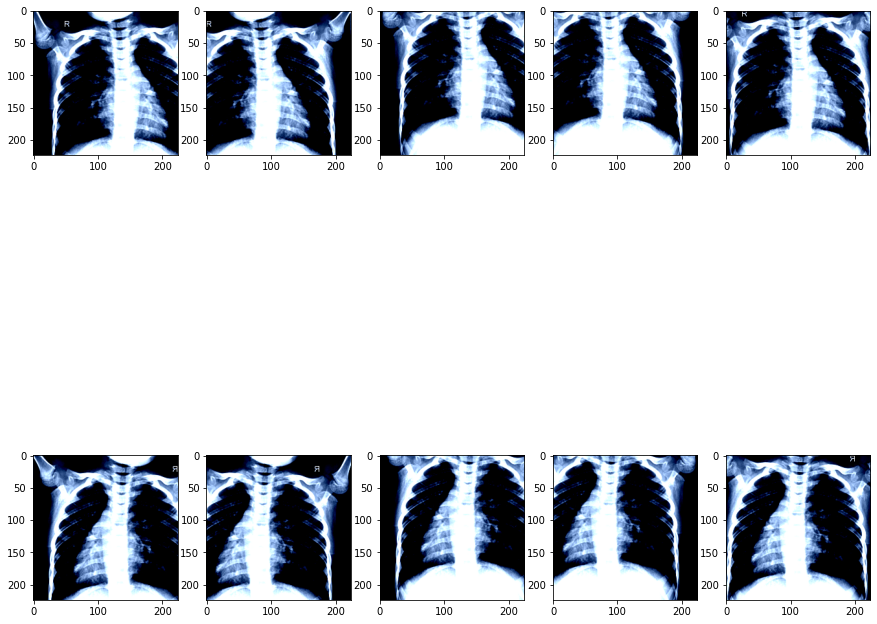

In [ ]:
f, axarr = plt.subplots(2,5)
f.set_figheight(15)
f.set_figwidth(15)
for i in range(2):
  for j in range(5):
    axarr[i][j].imshow(batch1[0][0][i*5+j].permute(1, 2, 0))

In [34]:
class arg:
    epochs = 10
    batch_size = 64
    lr = 0.001
    lr_decay = 0.9
    lam_recon = 0.0005 * 224 *224 #from 28 * 28
    r = 3 #default from paper
    shift_pixels = 2
    data_dir = './data'
    download = './download'

    save_dir = '/content/drive/My Drive/CovidAID/experimental/save_dir'
    weights = None
    testing = False
    # weights = '/content/drive/My Drive/CovidAID/experimental/save_dir/trained_model.pkl'
    # testing = True

args = arg()
print(arg.epochs)

10


In [35]:
# define model
model = CapsuleNet(input_size=[3, 224, 224], classes=3, routings=3)
model.cuda()
print(model)

#32*47*47 -> 7088
#32*x^2 -> 800
# x^2 = 25
# x = 5

CapsuleNet(
  (conv1): Conv2d(3, 256, kernel_size=(25, 25), stride=(2, 2))
  (primarycaps): PrimaryCapsule(
    (conv2d): Conv2d(256, 256, kernel_size=(25, 25), stride=(16, 16))
  )
  (capsulelayer): DenseCapsule()
  (digitcaps): DenseCapsule()
  (decoder): Sequential(
    (0): Linear(in_features=48, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=1024, out_features=150528, bias=True)
    (5): Sigmoid()
  )
  (relu): ReLU()
)


In [ ]:
# train or test
if args.weights is not None:  # init the model weights with provided one
    model.load_state_dict(torch.load(args.weights))
if not args.testing:
    save_name = '/pujo/trained_model_2.pkl'
    train(model, train_loader, test_loader, args, save_name)
else:  # testing
    if args.weights is None:
        print('No weights are provided. Will test using random initialized weights.')
    test_loss, test_acc = test(model=model, test_loader=test_loader, args=args)
    print('test acc = %.4f, test loss = %.5f' % (test_acc, test_loss))
    show_reconstruction(model, test_loader, 50, args)

Begin Training----------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:197: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


==> Epoch 00: loss=1.73401, val_loss=1.38576, val_acc=0.5963, time=36s
best val_acc increased to 0.5963
==> Epoch 01: loss=1.21029, val_loss=1.02264, val_acc=0.5963, time=35s
==> Epoch 02: loss=1.00259, val_loss=0.90168, val_acc=0.5963, time=34s
==> Epoch 03: loss=0.91371, val_loss=0.81029, val_acc=0.5963, time=34s
==> Epoch 04: loss=0.89847, val_loss=0.83323, val_acc=0.5963, time=36s
==> Epoch 05: loss=0.85281, val_loss=0.78426, val_acc=0.7110, time=34s
best val_acc increased to 0.7110
==> Epoch 06: loss=0.76902, val_loss=0.74325, val_acc=0.7982, time=34s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:197: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


test acc = 0.8333, test loss = 0.62904


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:177: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.



Reconstructed images are saved to /content/drive/My Drive/CovidAID/experimental/save_dir/real_and_recon.png
----------------------------------------------------------------------


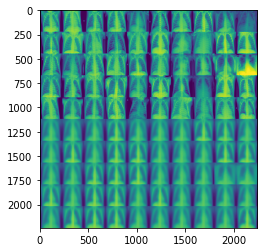

In [27]:
test_loss, test_acc = test(model=model, test_loader=test_loader, args=args)
print('test acc = %.4f, test loss = %.5f' % (test_acc, test_loss))
show_reconstruction(model, test_loader, 50, args)